In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

n = 800

data = pd.DataFrame({
    "Monthly_Amount": np.concatenate([np.random.normal(3000,500,300),
                                       np.random.normal(12000,1500,300),
                                       np.random.normal(35000,4000,200)]),
    "Txn_Count": np.concatenate([np.random.normal(12,3,300),
                                 np.random.normal(45,8,300),
                                 np.random.normal(110,20,200)]),
    "Avg_Ticket": np.concatenate([np.random.normal(250,40,300),
                                   np.random.normal(350,50,300),
                                   np.random.normal(900,150,200)]),
    "Dormancy_Days": np.concatenate([np.random.normal(90,15,300),
                                      np.random.normal(25,10,300),
                                      np.random.normal(7,3,200)])
})

scaler = StandardScaler()
X = scaler.fit_transform(data)

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)

data["Regime"] = gmm.predict(X)
probs = gmm.predict_proba(X)
data["Confidence"] = probs.max(axis=1)

data.head()


C:\Users\98412\miniconda3\envs\ai_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,Monthly_Amount,Txn_Count,Avg_Ticket,Dormancy_Days,Regime,Confidence
0,3248.357077,14.814851,242.684142,79.173937,0,1.0
1,2930.867849,10.451866,304.995057,92.652313,0,1.0
2,3323.844269,12.288362,224.161433,81.799799,0,1.0
3,3761.514928,10.613174,218.032320,85.925173,0,1.0
4,2882.923313,10.696511,230.690259,115.101781,0,1.0


In [2]:
worlds = data.groupby("Regime")[[
    "Monthly_Amount","Txn_Count","Avg_Ticket","Dormancy_Days"
]].mean()

worlds


,Monthly_Amount,Txn_Count,Avg_Ticket,Dormancy_Days
Regime,,,,
0,2997.225720,12.416677,252.379323,90.764662
1,35035.866584,111.652608,898.983331,6.581864
2,11967.765026,45.314242,349.248603,25.168955


In [3]:
data["Weight"] = 1
population = data.groupby("Regime")["Weight"].count()

population


Regime
0    300
1    200
2    300
Name: Weight, dtype: int64

In [4]:
data.groupby("Regime")["Confidence"].mean()


Regime
0    1.0
1    1.0
2    1.0
Name: Confidence, dtype: float64

In [5]:
world_actions = {
    0: "Reactivation Program",
    2: "Cross-Sell & Engagement",
    1: "Premium Relationship Strategy"
}

data["Recommended_Action"] = data["Regime"].map(world_actions)
data[["Monthly_Amount","Txn_Count","Regime","Confidence","Recommended_Action"]].head()


,Monthly_Amount,Txn_Count,Regime,Confidence,Recommended_Action
0,3248.357077,14.814851,0,1.0,Reactivation Program
1,2930.867849,10.451866,0,1.0,Reactivation Program
2,3323.844269,12.288362,0,1.0,Reactivation Program
3,3761.514928,10.613174,0,1.0,Reactivation Program
4,2882.923313,10.696511,0,1.0,Reactivation Program


In [6]:
data["Final_Action"] = np.where(
    data["Confidence"] > 0.75,
    data["Recommended_Action"],
    "Manual Review"
)

data[["Regime","Confidence","Final_Action"]].head()


,Regime,Confidence,Final_Action
0,0,1.0,Reactivation Program
1,0,1.0,Reactivation Program
2,0,1.0,Reactivation Program
3,0,1.0,Reactivation Program
4,0,1.0,Reactivation Program


In [7]:
noisy = data.copy()

for col in ["Monthly_Amount","Txn_Count","Avg_Ticket","Dormancy_Days"]:
    noisy[col] = noisy[col] * np.random.normal(1, 0.15, size=len(noisy))

X_noisy = scaler.transform(noisy[["Monthly_Amount","Txn_Count","Avg_Ticket","Dormancy_Days"]])

noisy["Regime"] = gmm.predict(X_noisy)
noisy["Confidence"] = gmm.predict_proba(X_noisy).max(axis=1)

noisy.groupby("Regime")["Confidence"].mean()


Regime
0    1.000000
1    0.999268
2    1.000000
Name: Confidence, dtype: float64

In [8]:
noisy["Final_Action"] = np.where(
    noisy["Confidence"] > 0.75,
    noisy["Regime"].map(world_actions),
    "Manual Review"
)

noisy["Final_Action"].value_counts()


Final_Action
Reactivation Program             300
Cross-Sell & Engagement          299
Premium Relationship Strategy    201
Name: count, dtype: int64

In [9]:
baseline = data.groupby("Regime")[[
    "Monthly_Amount","Txn_Count","Avg_Ticket","Dormancy_Days"
]].mean()
baseline


,Monthly_Amount,Txn_Count,Avg_Ticket,Dormancy_Days
Regime,,,,
0,2997.225720,12.416677,252.379323,90.764662
1,35035.866584,111.652608,898.983331,6.581864
2,11967.765026,45.314242,349.248603,25.168955


In [10]:
new_data = noisy.sample(150).copy()
new_X = scaler.transform(new_data[["Monthly_Amount","Txn_Count","Avg_Ticket","Dormancy_Days"]])

new_data["Regime"] = gmm.predict(new_X)

monitor = new_data.groupby("Regime")[[
    "Monthly_Amount","Txn_Count","Avg_Ticket","Dormancy_Days"
]].mean()

monitor


,Monthly_Amount,Txn_Count,Avg_Ticket,Dormancy_Days
Regime,,,,
0,2925.200761,12.246497,256.675920,87.009953
1,34094.527769,107.771109,875.735484,7.299432
2,11928.853311,46.108058,344.722875,26.326797


In [11]:
drift = ((monitor - baseline).abs() / baseline) * 100
drift


,Monthly_Amount,Txn_Count,Avg_Ticket,Dormancy_Days
Regime,,,,
0,2.403054,1.370582,1.702436,4.136752
1,2.686786,3.476407,2.586015,10.902206
2,0.325138,1.751803,1.295847,4.600281


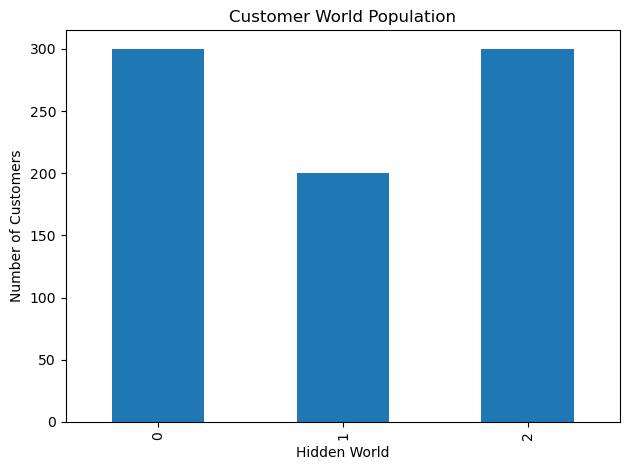

In [12]:
import matplotlib.pyplot as plt

world_pop = data["Regime"].value_counts().sort_index()

world_pop.plot(kind="bar")
plt.title("Customer World Population")
plt.xlabel("Hidden World")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()


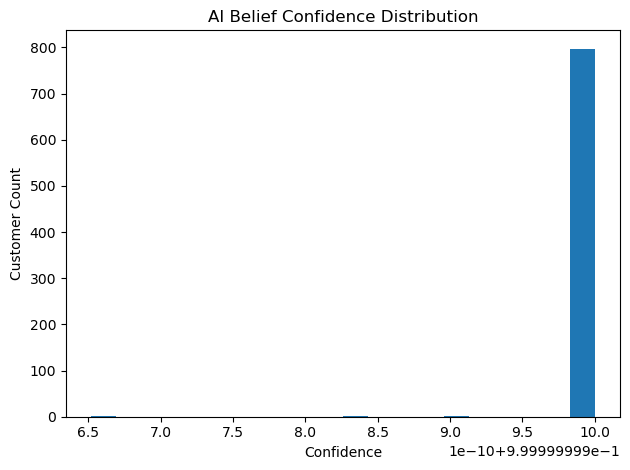

In [13]:
data["Confidence"].plot(kind="hist", bins=20)
plt.title("AI Belief Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()


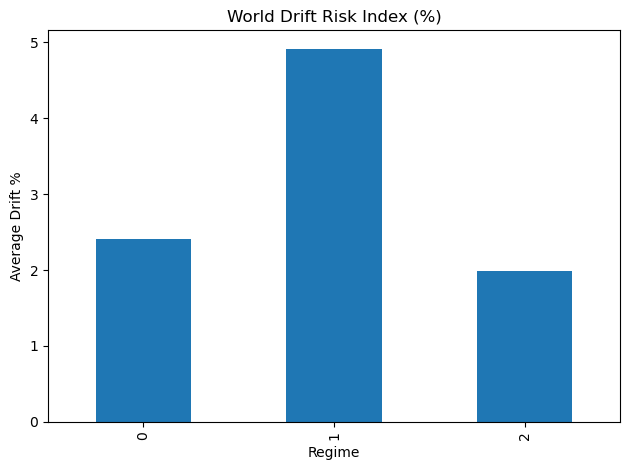

In [14]:
drift.mean(axis=1).plot(kind="bar")
plt.title("World Drift Risk Index (%)")
plt.ylabel("Average Drift %")
plt.tight_layout()
plt.show()


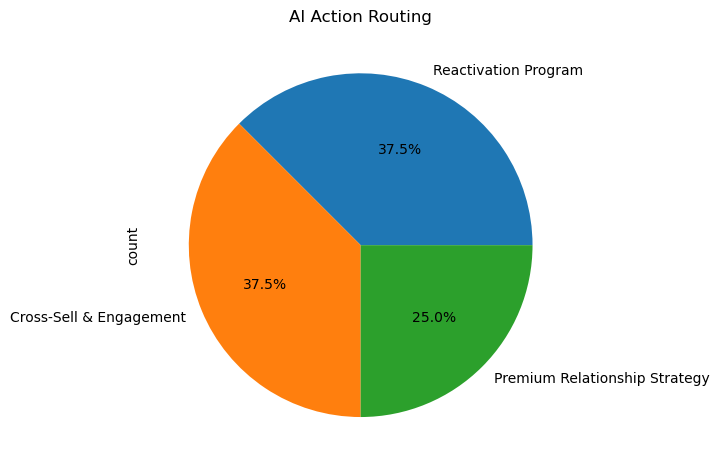

In [15]:
data["Final_Action"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("AI Action Routing")
plt.tight_layout()
plt.show()
